In [165]:
import torch
import torch.nn as nn
import random

In [2]:
device='cuda:1'

In [3]:
torch.manual_seed(0)

In [237]:
class Branch(nn.Module):
    def __init__(self, num_discr, num_branches):
        super(Branch, self).__init__()

        self.num_discr = num_discr

        self.backbone = nn.Sequential(
            nn.Linear(num_discr, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, num_branches)
        )

    def forward(self, x):
        x = self.backbone(x)
        #x = self.a2(x)
        return x


class Trunk(nn.Module):
    def __init__(self, num_branches):
        super(Trunk, self).__init__()

        self.num_branches = num_branches
        self.backbone = nn.Sequential(
            nn.Linear(3, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, 1024),
            nn.Tanh(),
            nn.Linear(1024, num_branches)
        )

    def forward(self, x):
        x = self.backbone(x)
        #x = self.a3(x)
        return x


class DeepONet(nn.Module):
    def __init__(self, num_branches, num_discr):
        super(DeepONet, self).__init__()

        #branch
        self.num_branches = num_branches
        self.branch = Branch(num_discr, num_branches)

        #trunk
        self.trunk = Trunk(num_branches)

        #output
        self.a3 = nn.Tanh()
        self.w4 = nn.Linear(num_branches, 1024)
        self.a4 = nn.Tanh()
        self.w5 = nn.Linear(1024, 1024)
        self.a5 = nn.Tanh()
        self.w6 = nn.Linear(1024, 1)

    def forward(self, x, t, a, ic):
        # x, t - inputs to solution, [batch_size x 1]
        # ic - initial condition, inputs to branch nets, [batch_size x num_discr]
        
        u = torch.cat((x, t, a), dim=1)
        u = self.trunk(u) * self.branch(ic)

        u = self.a3(u)
        u = self.w4(u)
        u = self.a4(u)
        u = self.w5(u)
        u = self.a5(u)
        u = self.w6(u)
        return u

In [238]:
def solution(x, t, n, alpha):
    return torch.exp(-alpha * n**2 * torch.pi**2 * t) * torch.sin(n * torch.pi * x)


def heat(model, x, t, alpha, ic_x):
    u = model(x, t, alpha, ic_x)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    return u_t - alpha * u_xx


def bc(x, t):
    # if t.grad is not None:
    #     t.grad.data.zero_()
    # y = trained_net(x, t)
    # t_grad = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(t), create_graph=True, retain_graph=True)[0]
    return 0.0 # + 0.1 * t_grad


def ic(x, n):
    # if x.grad is not None:
    #     x.grad.data.zero_()
    # y = trained_net(x, torch.zeros_like(x))
    # x_grad = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    return torch.sin(n * torch.pi * x) # + 0.1 * x_grad#torch.randn(*x.shape).to(device) * 0.1

In [239]:
iters = 50000
batch_size = 256
net = DeepONet(num_branches=1024, num_discr=1024)
net.to(device)

DeepONet(
  (branch): Branch(
    (backbone): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): Tanh()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): Tanh()
      (4): Linear(in_features=1024, out_features=1024, bias=True)
      (5): Tanh()
      (6): Linear(in_features=1024, out_features=1024, bias=True)
    )
  )
  (trunk): Trunk(
    (backbone): Sequential(
      (0): Linear(in_features=3, out_features=1024, bias=True)
      (1): Tanh()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): Tanh()
      (4): Linear(in_features=1024, out_features=1024, bias=True)
      (5): Tanh()
      (6): Linear(in_features=1024, out_features=1024, bias=True)
    )
  )
  (a3): Tanh()
  (w4): Linear(in_features=1024, out_features=1024, bias=True)
  (a4): Tanh()
  (w5): Linear(in_features=1024, out_features=1024, bias=True)
  (a5): Tanh()
  (w6): Linear(in_features=1024, out_features=1, bias=True)
)

In [240]:
optim = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', factor=0.5, patience=5)

In [241]:
for iter in range(iters):
    x = torch.rand(batch_size, 1, requires_grad=True) # x in [0, 1)
    t = torch.rand(batch_size, 1, requires_grad=True) # t in [0, 1)

    alpha = torch.full((batch_size, 1), fill_value=0.1)
    n = torch.full((batch_size, 1), fill_value=random.choice([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]))
    # alpha = torch.clamp(torch.rand(batch_size, 1), 1e-2, 1.0)
    # n = torch.rand(batch_size, 1) * 2 + 1.0
    
    ic_input = ic(torch.linspace(0.0, 1.0, 1024).unsqueeze(0).repeat([batch_size, 1]), n).to(device)

    x, t = x.to(device), t.to(device)
    n, alpha = n.to(device), alpha.to(device)

    def closure():
        optim.zero_grad()
        ic_loss = (net(x, torch.zeros_like(t), alpha, ic_input) - ic(x, n)) ** 2
        bc_loss = (net(torch.zeros_like(x), t, alpha, ic_input) - bc(torch.zeros_like(x), t)) ** 2 + (net(torch.ones_like(x), t, alpha, ic_input) - bc(torch.ones_like(x), t)) ** 2
        loss = heat(net, x, t, alpha, ic_input) ** 2 + bc_loss + ic_loss
        loss = loss.sum(0)
        loss.backward()
        return loss

    loss = optim.step(closure)

    iter_num = iter + 1
    if iter_num % 1000 == 0:
        print(f"[{iter_num}/{iters}] train loss: {loss.item():<.10f}")
        scheduler.step(loss.item())

[1000/50000] train loss: 106.6756668091
[2000/50000] train loss: 115.3784637451
[3000/50000] train loss: 113.9000549316
[4000/50000] train loss: 128.4219512939
[5000/50000] train loss: 3.6087319851
[6000/50000] train loss: 121.7569580078
[7000/50000] train loss: 2.0782399178
[8000/50000] train loss: 109.3764038086
[9000/50000] train loss: 16.0849838257
[10000/50000] train loss: 120.4608306885
[11000/50000] train loss: 113.7771911621
[12000/50000] train loss: 2.6743950844
[13000/50000] train loss: 35.6886825562
[14000/50000] train loss: 3.2885897160
[15000/50000] train loss: 128.5466003418
[16000/50000] train loss: 116.6894989014
[17000/50000] train loss: 35.3874206543
[18000/50000] train loss: 3.2862877846
[19000/50000] train loss: 4.5429902077
[20000/50000] train loss: 5.0714597702
[21000/50000] train loss: 0.6454806328
[22000/50000] train loss: 3.0565502644
[23000/50000] train loss: 121.9866333008
[24000/50000] train loss: 1.2745981216
[25000/50000] train loss: 2.4379582405
[26000/50

In [242]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

net.eval()

def plot_solution_preds(t, alpha=0.4, n=1.0, points=1000):
    x = torch.Tensor(np.linspace(0, 1, points))
    y = solution(x, torch.full(x.shape, fill_value=t), n, alpha).numpy()

    x_n = x.unsqueeze(1)
    x_n.requires_grad=True
    x_n = x_n.to(device)
    t_n = torch.full(x_n.shape, fill_value=t, requires_grad=True)
    t_n = t_n.to(device)
    n_n = torch.full(x_n.shape, fill_value=n)
    n_n = n_n.to(device)
    alpha_n = torch.full(x_n.shape, fill_value=alpha)
    alpha_n = alpha_n.to(device)

    y_ic = ic(x_n, n).squeeze().cpu().detach().numpy()

    if x_n.grad is not None:
        x_n.grad.data.zero_()
    if t_n.grad is not None:
        t_n.grad.data.zero_()

    with torch.no_grad():
        pred = net(
            torch.clip(x_n, 0.0, 1.0),
            torch.clip(t_n, 0.0, 1.0),
            alpha_n,
            ic(torch.linspace(0.0, 1.0, 1024), n).unsqueeze(0).to(device)
        ).squeeze().cpu().detach().numpy()

    plt.figure(figsize=(5, 5))
    plt.plot(x, y, label='GT')
    plt.plot(x, pred, label='predicted')
    plt.plot(x, y_ic, '--', label='IC')
    plt.title(f"T = {t:.3f}")
    plt.xlabel("x")
    plt.ylabel(f"u(x, t={t:.3f})")
    plt.ylim([-1.5, 1.5])
    plt.xlim([0.0, 1.0])
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"burgers_examples/img_{int(t*1000)}.png", bbox_inches='tight')
    plt.show()
    plt.close()

In [252]:
N = 7.0
alpha = 0.1

/tmp/ipykernel_44501/3513005132.py:23: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538621320/work/build/aten/src/ATen/core/TensorBody.h:489.)
  if x_n.grad is not None:
/tmp/ipykernel_44501/3513005132.py:25: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the le

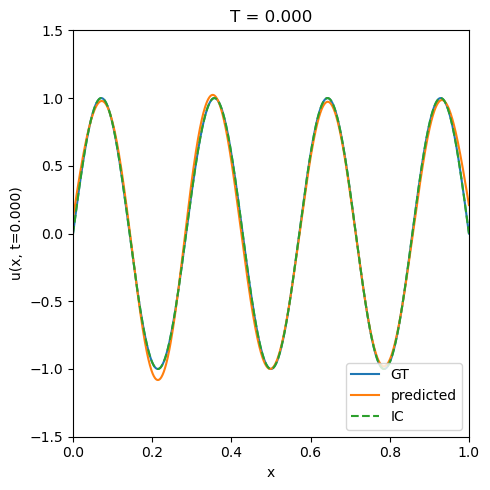

In [253]:
plot_solution_preds(0., alpha=alpha, n=N)

/tmp/ipykernel_44501/3513005132.py:23: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538621320/work/build/aten/src/ATen/core/TensorBody.h:489.)
  if x_n.grad is not None:
/tmp/ipykernel_44501/3513005132.py:25: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the le

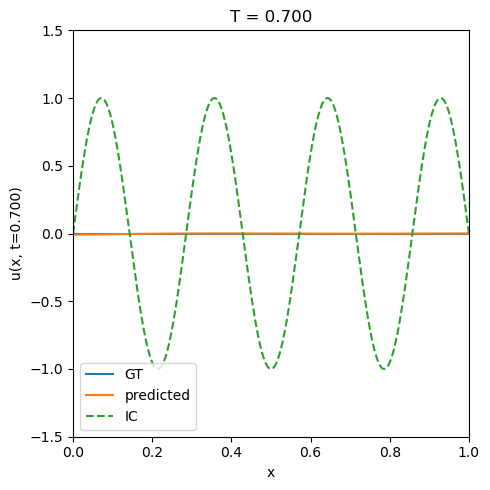

In [254]:
plot_solution_preds(0.7, alpha=alpha, n=N)